construct and train model -
multi-layer perceptron neural network model implementation on MNIST data

In [3]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# define the model
class MLPerceptron(nn.Module):
    def __init__(self):
        super(MLPerceptron, self).__init__()
        input_size = 28 * 28
        hidden_size = 128
        output_size = 10
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, hidden_size)
        self.layer4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.layer4(x)
        return x

# define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# download and load the data
dataset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)

# split the dataset into training and validation sets
training_size = int(0.8 * len(dataset))  # 80% for training
validation_size = len(dataset) - training_size  # 20% for validation
training_data, validation_data = random_split(dataset, [training_size, validation_size])

# create training and validation data loaders
training_loader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=True)

# instantiate the model, loss criterion, and optimizer
model = MLPerceptron() # multi-layer perceptron model
loss_criterion = nn.MSELoss() # mean squared error loss function
optimizer = optim.SGD(model.parameters(), lr=0.8) # stochaistic gradient descent

print(model)

# number of epochs
n_epochs = 30

# training and validation
for epoch in range(n_epochs):
    # training
    model.train()
    training_loss = 0.0
    for inputs, labels in training_loader:
        # zero the parameter gradients
        optimizer.zero_grad()

        # reshape the inputs and forward pass
        inputs = inputs.view(inputs.shape[0], -1)
        outputs = model(inputs)

        # transform labels to match the output shape
        labels = nn.functional.one_hot(labels, num_classes=10).float()

        # calculate loss
        loss = loss_criterion(outputs, labels)
        training_loss += loss.item()

        # backward pass and optimization
        loss.backward()
        optimizer.step()

    # calculate average loss over an epoch
    training_loss = training_loss / len(training_loader)

    # validation loss
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.view(inputs.shape[0], -1)
            outputs = model(inputs)
            labels = nn.functional.one_hot(labels, num_classes=10).float()
            loss = loss_criterion(outputs, labels)
            validation_loss += loss.item()
    validation_loss = validation_loss / len(validation_loader)        

    print('epoch: {} \ttraining loss: {:.6f} \tvalidation loss: {:.6f}'.format(epoch+1, training_loss, validation_loss))

MLPerceptron(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=10, bias=True)
)
epoch: 1 	training loss: 0.027741 	validation loss: 0.013113
epoch: 2 	training loss: 0.012030 	validation loss: 0.009290
epoch: 3 	training loss: 0.008943 	validation loss: 0.007780
epoch: 4 	training loss: 0.007466 	validation loss: 0.007016
epoch: 5 	training loss: 0.006309 	validation loss: 0.006315
epoch: 6 	training loss: 0.005600 	validation loss: 0.005779
epoch: 7 	training loss: 0.005042 	validation loss: 0.005609
epoch: 8 	training loss: 0.004511 	validation loss: 0.004918
epoch: 9 	training loss: 0.004115 	validation loss: 0.004672
epoch: 10 	training loss: 0.003755 	validation loss: 0.004336
epoch: 11 	training loss: 0.003452 	validation loss: 0.005070
epoch: 12 	training loss: 0.003219 	validation loss:

model validation

In [4]:
# validation
model.eval()
correct = 0
total = 0
error_inputs = []
error_labels = []
error_predictions = []

with torch.no_grad():
    for inputs, labels in validation_loader:
        inputs = inputs.view(inputs.shape[0], -1)
        outputs = model(inputs)
        
        # get the predicted class for each sample in the batch
        _, predicted = torch.max(outputs, 1)
        
        # count total number of labels and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # store inputs, labels, and predictions where predictions are incorrect
        for i, label in enumerate(labels):
            if label != predicted[i]:
                error_labels.append(label.item())
                error_inputs.append(inputs[i])
                error_predictions.append(predicted[i].item())

# calculate the percentage of correct predictions
accuracy = correct / total * 100

print('model accuracy: {:.2f}%'.format(accuracy))

model accuracy: 98.07%


torch.Size([784])
model prediction: 5   label: 3


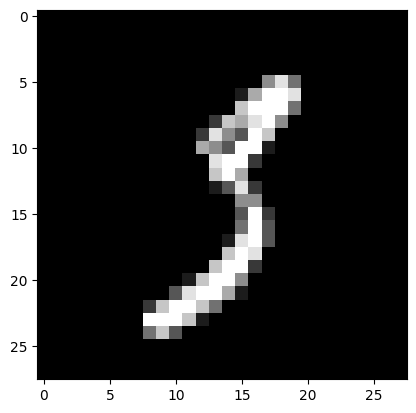

In [9]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

ind = 0
input = error_inputs[ind]
label = error_labels[ind]
prediction = error_predictions[ind]

print(input.size())

# ensure the tensor is of correct shape
input_tensor = input.view(1, -1)  # reshape to [1, 784] if it's not already

# unnormalize the image
unnorm_tensor = input * 0.5 + 0.5

# convert to PIL Image
img = to_pil_image(unnorm_tensor.reshape([28, 28]))

print(f'model prediction: {prediction}   label: {label}')

# display the image
plt.imshow(img, cmap='gray')
plt.show()
